# Onboarding Challenge

In [25]:
import os
import matplotlib
import matplotlib.pyplot as plt
from muselsl import stream, list_muses, view, record
from multiprocessing import Process
from time import strftime, gmtime
from csv import reader
from collections import OrderedDict
import numpy as np
import copy

## Read the prerecorded file
Before doing anything with our data, we want to see what it looks like.

In [2]:
EEG_DATA_FILE_NAME = os.path.join("eeg-records", "recording-2019-09-10-02.06.47.csv")

In [3]:
eeg_data = OrderedDict()

with open(EEG_DATA_FILE_NAME, newline='') as eeg_file:
    csv_reader = reader(eeg_file, delimiter=',')
    for i, samples in enumerate(csv_reader):
        if i is  0:
            eeg_data = {key:[] for key in samples }
        else:
            for j, key in enumerate(eeg_data.keys()):
                eeg_data[key].append(float(samples[j]))

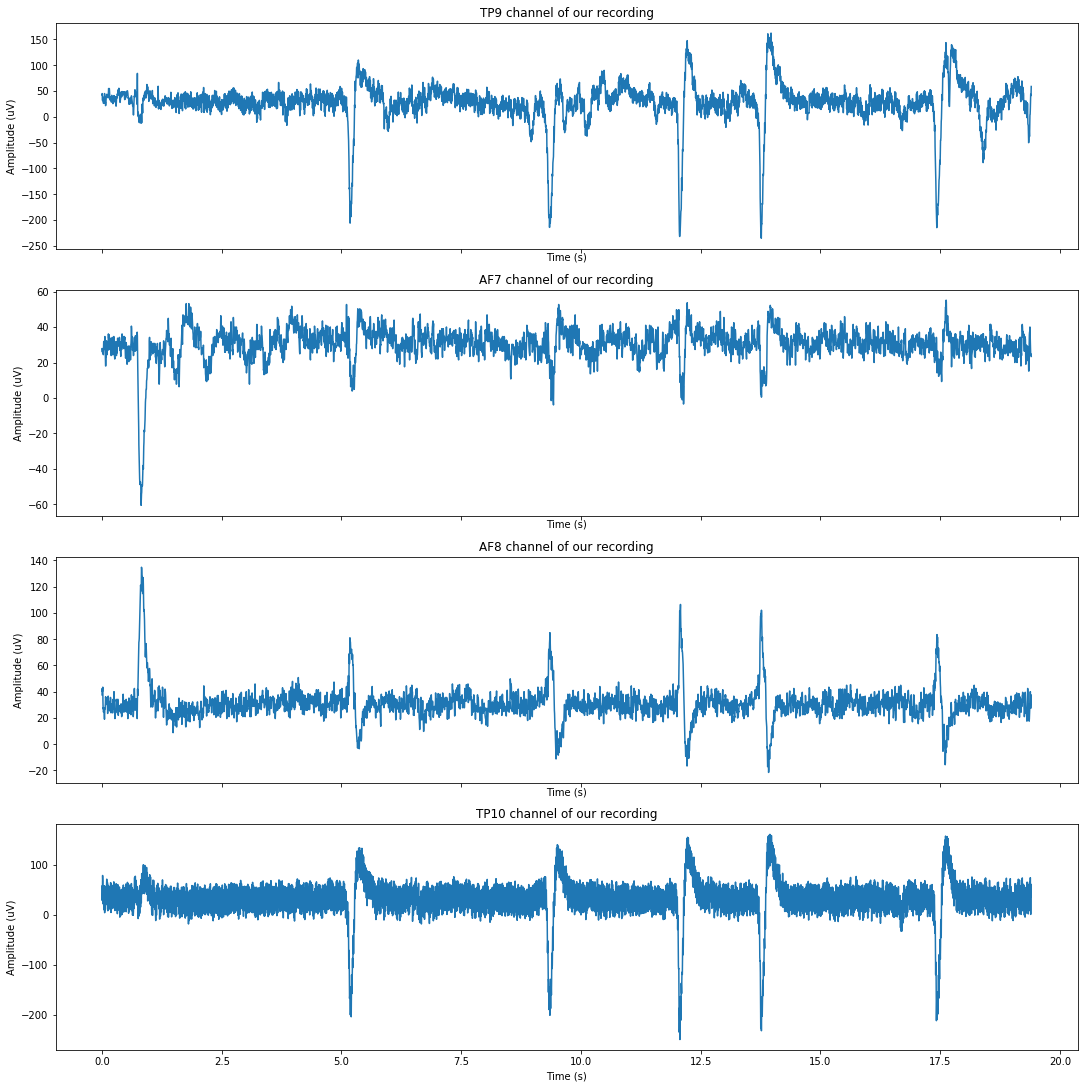

In [4]:
# This will set the time reference in seconds starting at 0 seconds.
eeg_data['timestamps'] = [float(data) - float(eeg_data['timestamps'][0]) for data in eeg_data['timestamps']]

fig, axes = plt.subplots(4, 1, constrained_layout=True, sharex=True, figsize=[15,15])

# Plot the TP9 channel
axes[0].set_title('TP9 channel of our recording')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude (uV)')
axes[0].plot(eeg_data['timestamps'], eeg_data['TP9'])

# Plot the AF7 channel
axes[1].set_title('AF7 channel of our recording')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Amplitude (uV)')
axes[1].plot(eeg_data['timestamps'], eeg_data['AF7'])

# Plot the AF8 channel
axes[2].set_title('AF8 channel of our recording')
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('Amplitude (uV)')
axes[2].plot(eeg_data['timestamps'], eeg_data['AF8'])

# Plot the TP10 channel
axes[3].set_title('TP10 channel of our recording')
axes[3].set_xlabel('Time (s)')
axes[3].set_ylabel('Amplitude (uV)')
axes[3].plot(eeg_data['timestamps'], eeg_data['TP10'])

# We're not plotting Right Aux channel since we're not using an extra channel.

As we can see, there are some huge spikes in the data. This is caused by eyes blinking and the muscle signal propagating to the headset electrodes. The TP channels seem to have more important spikes in amplitude than the AF channels. This is caused by the fact that these last are closer to the reference electrode that cancel the blinking signal. TP spikes are negative since a high potential is detected on the ref electrode, causing the TP channel to be substracted by a high number.

## Detect eye blinks

To begin, we'll filter the TP10 channel since it has the most steep curves when a blink occurs.

### Doing it the simple way

We can see that a blink artefact corresponds to a steep spike in the signal. For that channel, the amplitude goes down when the eye closes and goes up when it opens. So what we could to do is simply to apply a threshold on the absolute value of the amplitude. To pick the threshold, lets plot an histogram of the amplitudes occurences.

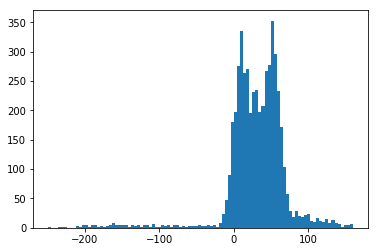

In [5]:
plt.hist(eeg_data['TP10'], 100)
plt.show()

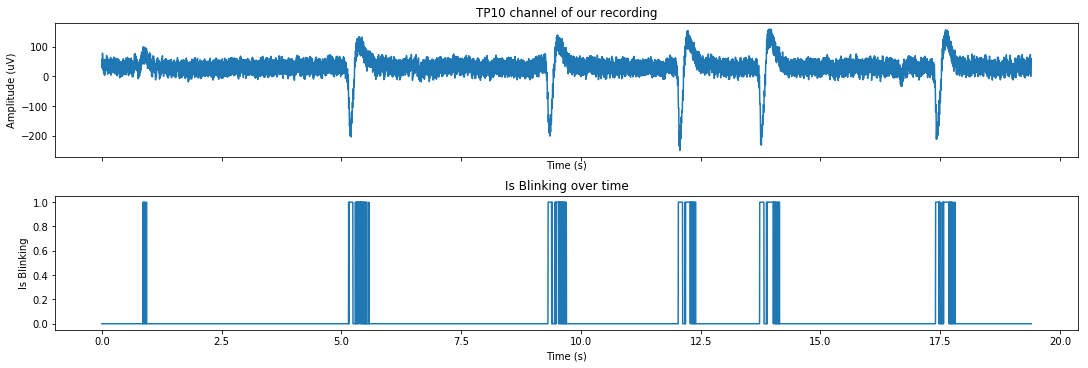

In [6]:
# We want indexes that are superior to a threshold. This is completly a arbitrary value based of our observation of the signal's plot. 
THRESHOLD = 85 # We picked this number based on the previous histogram.
blink_data = [abs(amplitude) > THRESHOLD for amplitude in eeg_data['TP10']]


fig, axes = plt.subplots(2, 1, constrained_layout=True, sharex=True, figsize=[15,5])

# Plot the TP10 channel
axes[0].set_title('TP10 channel of our recording')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude (uV)')
axes[0].plot(eeg_data['timestamps'], eeg_data['TP10'])

# Plot the blink data
axes[1].set_title('Is Blinking over time')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Is Blinking')
axes[1].plot(eeg_data['timestamps'], blink_data)

We can add some debouncing on to ensure that we only have one rising edge for the isblinking signal when there's an eye bline.

In [23]:
DEBOUNCING = 0.1
PERIOD = 1/256
FREQUENCY = 1/PERIOD

rising_edges = []
falling_edges = []

last_value = blink_data[0]
for i, data in enumerate(blink_data):
    if data is not last_value:
        if last_value:
            falling_edges.append(i)
        else:
            rising_edges.append(i)
    last_value = data

for i in falling_edges:
    next_rising_edges = [index for index in rising_edges if index > i]
    if len(next_rising_edges) != 0 and (next_rising_edges[0] - i) * PERIOD < DEBOUNCING:
        for j in range(i, next_rising_edges[0]):
            blink_data[j] = True

        

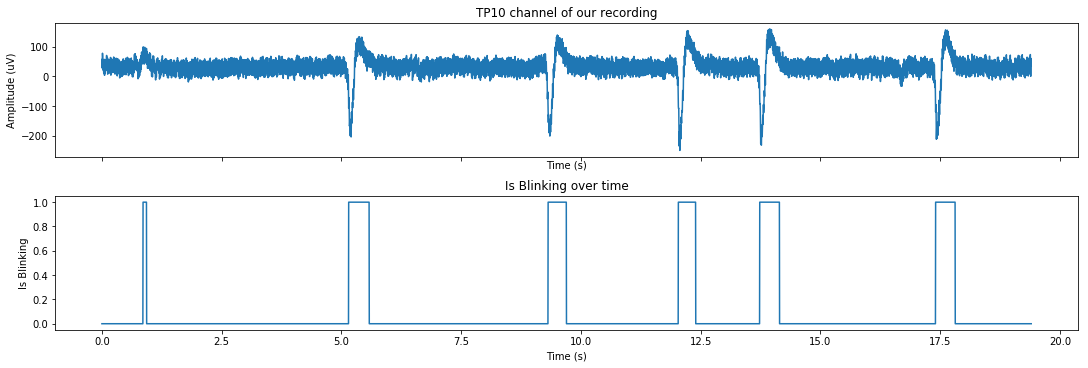

In [22]:
fig, axes = plt.subplots(2, 1, constrained_layout=True, sharex=True, figsize=[15,5])

# Plot the TP10 channel
axes[0].set_title('TP10 channel of our recording')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude (uV)')
axes[0].plot(eeg_data['timestamps'], eeg_data['TP10'])

# Plot the blink data
axes[1].set_title('Is Blinking over time')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Is Blinking')
axes[1].plot(eeg_data['timestamps'], blink_data)

### Some issues with the previous method
The simple threshold value method is good, but requires a human intervention to set the threshold. Indeed, this threshold must be manually set for every recording of data since change in signal amplitude due to blinking can vary a lot (e.g. from subject to another). Also, doing it this way is only valid for signal centered around the y = 0 axis. It is also usual for a signal to have its mean shifted during a recording.

### [TKEO algorithm](https://drive.google.com/open?id=1N9ARGXhnCmY9S7QUc8uIdMRM9L1OF6Ao) before setting threshold
Since the previously used threshold is determined arbitrarily, a better solution would be to normalize the signal and set a treshold that would be valid for signals of different subjects.

One way of acheving this could be to use the TKEO method to put emphasis on data points that have great changes in amplitude. We could then calculate the z-score of a given data point and set a z-score threshold (still a little bit arbitrary but at least the criteria can be automatically set) to detect a blink.

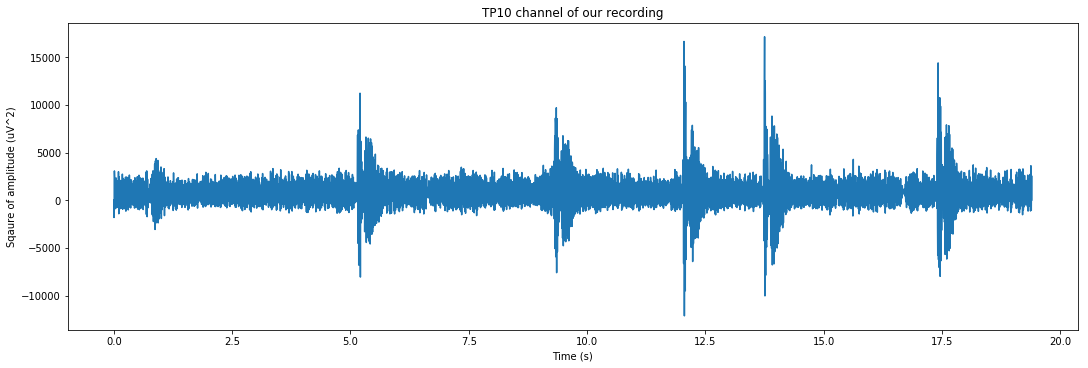

In [20]:
tkeo_eeg_data = copy.deepcopy(eeg_data['TP10'])

# the loop version for interpretability
for i in range(1,len(tkeo_eeg_data)-1):
    tkeo_eeg_data[i] = eeg_data['TP10'][i]**2 - eeg_data['TP10'][i-1]*eeg_data['TP10'][i+1]
    
fig, axes = plt.subplots(1, 1, constrained_layout=True, sharex=True, figsize=[15,5])

# Plot the TP10 channel
axes.set_title('TP10 channel of our recording')
axes.set_xlabel('Time (s)')
axes.set_ylabel('Sqaure of amplitude (uV^2)')
axes.plot(eeg_data['timestamps'], tkeo_eeg_data)

In order to compare both signals, we have to put them in the same scale. The original signal has an amplitude in microvolts, whereas the TKEO signal has an amplitude of squared microvolts. We can put them in the same scale by comparing their z-score, meaning we will look at how far the signal is compared to the standard deviation and the mean.

The standard deviation and the mean will be calculated from a subpart of the signal that does not contain artefact. We will take the first 4 seconds from the TP10 channel.

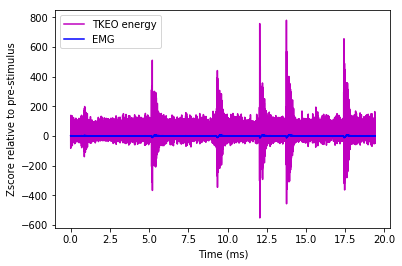

In [35]:
a = 4*FREQUENCY

tp10_mean_signal = np.mean(eeg_data["TP10"][0:int(4*FREQUENCY)])
tp10_standard_deviation = np.std(eeg_data["TP10"][0:int(4*FREQUENCY)])

tp10_eeg_data_zscore = (eeg_data["TP10"] - tp10_mean_signal) / tp10_standard_deviation
tp10_tkeo_eeg_zscore = (tkeo_eeg_data - tp10_mean_signal) / tp10_standard_deviation

# plot zscored
plt.plot(eeg_data["timestamps"],tp10_tkeo_eeg_zscore,'m',label='TKEO energy')
plt.plot(eeg_data["timestamps"],tp10_eeg_data_zscore,'b',label='EMG')

plt.xlabel('Time (ms)')
plt.ylabel('Zscore relative to pre-stimulus')
plt.legend()
plt.show()

# Record an EEG signal

In [9]:
muses = list_muses()
if len(muses):
    stream_process = Process(target=stream, args=(muses[0]['address'],))
    stream_process.start()

Searching for Muses, this may take up to 10 seconds...
Found device Muse-8A60, MAC Address 00:55:DA:B3:8A:60
Connecting to Muse: 00:55:DA:B3:8A:60...
Connected.
Streaming EEG...
Disconnected.


In [ ]:
#view(backend="Qt5Agg")  # Use Tk backend on Windows
view(backend="MacOSX")

In [10]:
DURATION = 20  # secs
RECORDING_PATH = os.path.join("eeg-records", "recording-%s.csv" % strftime("%Y-%m-%d-%H.%M.%S", gmtime()))

In [11]:
recording_process = Process(target=record, args=(DURATION, RECORDING_PATH))
recording_process.start()

Looking for a EEG stream...
Started acquiring data.
Looking for a Markers stream...
Can't find Markers stream.
Start recording at time t=1568404979.318
Time correction:  -2.0790990674868226e-05
Time correction:  -2.771749859675765e-05
Done - wrote file: eeg-records/recording-2019-09-13-20.02.52.csv.
